## 0. Cargar librerías y datos

In [96]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from math import pi

In [97]:
ruta_raw_interlub   = "data/datos_grasas_Tec_limpio.csv"
ruta_model_interlub = "data/datos_grasas_Interlub_limpios_v2.csv"
ruta_model_comp     = "data/competidores_preprocesados.csv"

df_interlub_raw   = pd.read_csv(ruta_raw_interlub)
df_interlub_model = pd.read_csv(ruta_model_interlub)
df_comp_model     = pd.read_csv(ruta_model_comp)

print("RAW Interlub:", df_interlub_raw.shape)
print("Modelo Interlub (preprocesado):", df_interlub_model.shape)
print("Modelo competidores:", df_comp_model.shape)

feature_cols = df_interlub_model.columns.tolist()

RAW Interlub: (51, 26)
Modelo Interlub (preprocesado): (51, 49)
Modelo competidores: (14, 49)


## 1. Preparación de los dataframes

In [98]:
def preparar_df_grasas_raw(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    cols_drop = [
        "idDatosGrasas", "codigoGrasa", "Registro NSF", "categoria",
        "subtitulo", "descripcion", "beneficios", "aplicaciones",
        "Grado NLGI Consistencia"          # la quitamos del modelo
    ]
    cols_drop = [c for c in cols_drop if c in df.columns]
    df = df.drop(columns=cols_drop)

    cols_num = [
        "Viscosidad del Aceite Base a 40°C. cSt",
        "Penetración de Cono a 25°C, 0.1mm",
        "Punto de Gota, °C",
        "Estabilidad Mecánica, %",
        "Punto de Soldadura Cuatro Bolas, kgf",
        "Desgaste Cuatro Bolas, mm",
        "Indice de Carga-Desgaste",
        "Carga Timken Ok, lb",
        "Resistencia al Lavado por Agua a 80°C, %",
        "Factor de Velocidad",
        "Temperatura de Servicio °C, min",
        "Temperatura de Servicio °C, max",
    ]
    for col in cols_num:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

df_interlub_raw = preparar_df_grasas_raw(df_interlub_raw)
df_interlub_raw.head()

,Aceite Base,Espesante,Viscosidad del Aceite Base a 40°C. cSt,"Penetración de Cono a 25°C, 0.1mm","Punto de Gota, °C","Estabilidad Mecánica, %","Punto de Soldadura Cuatro Bolas, kgf","Desgaste Cuatro Bolas, mm",Indice de Carga-Desgaste,"Carga Timken Ok, lb","Resistencia al Lavado por Agua a 80°C, %",Corrosión al Cobre,Factor de Velocidad,"Temperatura de Servicio °C, min","Temperatura de Servicio °C, max",color,textura
0,Semi-Sintetico,Complejo Sulfonato de Calcio,680.0,279.0,304,1.07,500.0,NaN,NaN,60.0,0.58,NaN,200000.0,5,220,CafÃ©,Suave
1,Mineral HT,Complejo Sulfonato de Calcio,460.0,300.0,304,2.60,900.0,0.50,166.0,70.0,3.00,1a,300000.0,-30,150,Negro,Adherente
2,Mineral HT,Complejo Sulfonato de Calcio,460.0,280.0,300,10.00,500.0,0.48,NaN,NaN,3.00,NaN,NaN,-10,150,Negro,Adherente
3,Mineral HT,Complejo Sulfonato de Calcio,220.0,280.5,300,5.00,500.0,0.45,NaN,NaN,3.00,NaN,NaN,-15,150,Ambar,Suave
4,Mineral HT,Complejo de Aluminio - Poliurea,680.0,295.0,260,6.50,620.0,0.48,NaN,50.0,1.45,1a,NaN,-5,150,Negro,Adherente


## 2. Definir requerimientos del usuario

In [99]:
TEMP_FEATURES_RAW = [
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max",
    "Punto de Gota, °C",
]

CARGA_FEATURES_RAW = [
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Carga Timken Ok, lb",
    "Indice de Carga-Desgaste",
]

AGUA_FEATURES_RAW = [
    "Resistencia al Lavado por Agua a 80°C, %",
]

VISC_FEATURES_RAW = [
    "Viscosidad del Aceite Base a 40°C. cSt",
]

# pesos del score final
WEIGHTS = {
    "global": 0.4,
    "temp":   0.25,
    "carga":  0.2,
    "agua":   0.1,
    "visc":   0.05,
}

# Normalizamos por si no suman 1
w_sum = sum(WEIGHTS.values())
WEIGHTS = {k: v / w_sum for k, v in WEIGHTS.items()}
WEIGHTS

{'global': 0.4, 'temp': 0.25, 'carga': 0.2, 'agua': 0.1, 'visc': 0.05}

## 3. Recomendación y visualización de resultados

In [100]:
def filtrar_por_requisitos_raw(df_raw: pd.DataFrame, req: dict) -> pd.DataFrame:
    df_f = df_raw.copy()

    # Rango de temperatura
    if req.get("T_min") is not None:
        df_f = df_f[df_f["Temperatura de Servicio °C, min"] <= req["T_min"]]

    if req.get("T_max") is not None:
        df_f = df_f[df_f["Temperatura de Servicio °C, max"] >= req["T_max"]]

    # Ambiente con agua
    if req.get("ambiente_agua", False):
        if "Resistencia al Lavado por Agua a 80°C, %" in df_f.columns:
            umbral = df_f["Resistencia al Lavado por Agua a 80°C, %"].quantile(0.75)
            df_f = df_f[df_f["Resistencia al Lavado por Agua a 80°C, %"] <= umbral]

    # Carga mecánica
    carga = req.get("carga", None)
    if carga in ["media", "alta", "extrema"]:
        if "Punto de Soldadura Cuatro Bolas, kgf" in df_f.columns:
            q_map = {"media": 0.4, "alta": 0.6, "extrema": 0.8}
            q = q_map[carga]
            umbral_4b = df_f["Punto de Soldadura Cuatro Bolas, kgf"].quantile(q)
            df_f = df_f[df_f["Punto de Soldadura Cuatro Bolas, kgf"] >= umbral_4b]

    return df_f


In [101]:
def construir_fila_cliente_raw(df_raw: pd.DataFrame, req: dict) -> pd.DataFrame:
    fila = df_raw.mean(numeric_only=True)

    if req.get("T_min") is not None:
        fila["Temperatura de Servicio °C, min"] = req["T_min"]
    if req.get("T_max") is not None:
        fila["Temperatura de Servicio °C, max"] = req["T_max"]

    if req.get("carga") in ["alta", "extrema"]:
        if "Punto de Soldadura Cuatro Bolas, kgf" in df_raw.columns:
            fila["Punto de Soldadura Cuatro Bolas, kgf"] = df_raw["Punto de Soldadura Cuatro Bolas, kgf"].quantile(0.9)
        if "Carga Timken Ok, lb" in df_raw.columns:
            fila["Carga Timken Ok, lb"] = df_raw["Carga Timken Ok, lb"].quantile(0.9)

    if req.get("ambiente_agua", False):
        if "Resistencia al Lavado por Agua a 80°C, %" in df_raw.columns:
            fila["Resistencia al Lavado por Agua a 80°C, %"] = df_raw["Resistencia al Lavado por Agua a 80°C, %"].quantile(0.1)

    return fila.to_frame().T

In [102]:
def construir_mapa_raw_a_model(feature_cols):
    """
    Devuelve:
      - raw_to_model: dict raw_name -> nombre columna num__...
      - idx_groups: índices de features por grupo (temp, carga, agua, visc)
    """
    raw_to_model = {}
    for col in feature_cols:
        if col.startswith("num__"):
            base = col.replace("num__", "")
            raw_to_model[base] = col

    def get_indices(raw_list):
        names = []
        for raw_name in raw_list:
            model_name = raw_to_model.get(raw_name, None)
            if model_name is not None and model_name in feature_cols:
                names.append(model_name)
        return [feature_cols.index(n) for n in names]

    idx_temp = get_indices(TEMP_FEATURES_RAW)
    idx_carga = get_indices(CARGA_FEATURES_RAW)
    idx_agua = get_indices(AGUA_FEATURES_RAW)
    idx_visc = get_indices(VISC_FEATURES_RAW)

    idx_groups = {
        "temp": idx_temp,
        "carga": idx_carga,
        "agua": idx_agua,
        "visc": idx_visc,
    }

    return raw_to_model, idx_groups

raw_to_model, idx_groups = construir_mapa_raw_a_model(feature_cols)
idx_groups

{'temp': [11, 12, 3], 'carga': [5, 8, 7], 'agua': [9], 'visc': [1]}

In [103]:
def mapear_raw_a_preprocesado(fila_raw: pd.Series,
                              df_model: pd.DataFrame,
                              raw_to_model: dict) -> pd.DataFrame:
    """
    Toma una fila en espacio RAW y genera una fila equivalente
    en el espacio preprocesado (num__/cat__).
    Ahora solo 'inyectamos' los num__ que tienen correspondencia directa.
    Para las demás columnas (categorías, etc.) usamos el promedio del modelo.
    """
    fila_model = df_model.mean().copy()

    for raw_name, model_name in raw_to_model.items():
        if raw_name in fila_raw.index and model_name in df_model.columns:
            fila_model[model_name] = fila_raw[raw_name]

    return fila_model.to_frame().T

In [104]:
def sim_cos_component(X_ideal, X_cands, idxs):
    """Cosine similarity restringida a cierto subconjunto de columnas."""
    if not idxs:
        return None
    return cosine_similarity(X_ideal[:, idxs], X_cands[:, idxs])[0]

def construir_scores(
    X_ideal: np.ndarray,
    X_cands: np.ndarray,
    idx_groups: dict,
    weights: dict
):
    # Similaridad global
    sim_global = cosine_similarity(X_ideal, X_cands)[0]

    # Similitudes por grupo
    sim_temp  = sim_cos_component(X_ideal, X_cands, idx_groups["temp"])
    sim_carga = sim_cos_component(X_ideal, X_cands, idx_groups["carga"])
    sim_agua  = sim_cos_component(X_ideal, X_cands, idx_groups["agua"])
    sim_visc  = sim_cos_component(X_ideal, X_cands, idx_groups["visc"])

    # Sustituimos None por 0 para combinación
    sims = {
        "global": sim_global,
        "temp":   sim_temp  if sim_temp  is not None else np.zeros_like(sim_global),
        "carga":  sim_carga if sim_carga is not None else np.zeros_like(sim_global),
        "agua":   sim_agua  if sim_agua  is not None else np.zeros_like(sim_global),
        "visc":   sim_visc  if sim_visc  is not None else np.zeros_like(sim_global),
    }

    # Score final ponderado
    score = (
        weights["global"] * sims["global"]
        + weights["temp"] * sims["temp"]
        + weights["carga"] * sims["carga"]
        + weights["agua"] * sims["agua"]
        + weights["visc"] * sims["visc"]
    )

    return sims, score

In [105]:
def recomendar_interlub_pro(req: dict,
                            df_raw: pd.DataFrame,
                            df_model: pd.DataFrame,
                            feature_cols,
                            raw_to_model: dict,
                            idx_groups: dict,
                            weights: dict,
                            top_n: int = 5):
    # 1) Filtrar en RAW
    df_cands_raw = filtrar_por_requisitos_raw(df_raw, req)
    if df_cands_raw.empty:
        print("⚠️ No hay grasas que cumplan los requisitos.")
        return None

    # 2) Empatar índices con el modelo preprocesado
    idx_cands = df_cands_raw.index
    df_cands_model = df_model.iloc[idx_cands]

    # 3) Vector ideal en RAW
    fila_cliente_raw = construir_fila_cliente_raw(df_raw, req)

    # 4) Map RAW → modelo
    fila_cliente_model = mapear_raw_a_preprocesado(
        fila_cliente_raw.iloc[0], df_model, raw_to_model
    )

    # 5) Extraer matrices numéricas
    X_ideal = fila_cliente_model[feature_cols].values
    X_cands = df_cands_model[feature_cols].values

    # 6) Construir scores
    sims, score_final = construir_scores(
        X_ideal, X_cands, idx_groups, weights
    )

    # 7) Armar DataFrame de salida
    df_out = df_cands_raw.copy()
    df_out["sim_global"] = sims["global"]
    df_out["sim_temp"]   = sims["temp"]
    df_out["sim_carga"]  = sims["carga"]
    df_out["sim_agua"]   = sims["agua"]
    df_out["sim_visc"]   = sims["visc"]
    df_out["score"]      = score_final

    # Normalizar score a 0–100
    s_min, s_max = df_out["score"].min(), df_out["score"].max()
    if s_max > s_min:
        df_out["score_norm"] = 100 * (df_out["score"] - s_min) / (s_max - s_min)
    else:
        df_out["score_norm"] = 50.0

    df_out = df_out.sort_values("score", ascending=False)
    df_top = df_out.head(top_n).copy()
    
    explicaciones = []

    for _, row in df_top.iterrows():
        partes = []

        # --- Temperatura mínima ---
        if req.get("T_min") is not None:
            diff_min = row["Temperatura de Servicio °C, min"] - req["T_min"]
            if diff_min <= 0:
                partes.append(f"Temp mínima: ✔️ cumple ({row['Temperatura de Servicio °C, min']}°C ≤ {req['T_min']}°C)")
            else:
                partes.append(f"Temp mínima: ⚠️ no cumple (necesita ≤ {req['T_min']}°C)")

        # --- Temperatura máxima ---
        if req.get("T_max") is not None:
            diff_max = row["Temperatura de Servicio °C, max"] - req["T_max"]
            if diff_max >= 0:
                partes.append(f"Temp máxima: ✔️ cumple ({row['Temperatura de Servicio °C, max']}°C ≥ {req['T_max']}°C)")
            else:
                partes.append(f"Temp máxima: ⚠️ insuficiente ({row['Temperatura de Servicio °C, max']}°C < {req['T_max']}°C)")

        # --- Lavado por agua ---
        if req.get("ambiente_agua", False):
            lavado_percentil = df_interlub_raw["Resistencia al Lavado por Agua a 80°C, %"].rank(pct=True)[row.name]
            if lavado_percentil <= 0.25:
                partes.append("Lavado: 💧 excelente (muy resistente)")
            elif lavado_percentil <= 0.50:
                partes.append("Lavado: bueno")
            else:
                partes.append("Lavado: regular o alto")

        # --- Carga / Punto 4 bolas ---
        if "Punto de Soldadura Cuatro Bolas, kgf" in df_top.columns:
            carga_pct = df_interlub_raw["Punto de Soldadura Cuatro Bolas, kgf"].rank(pct=True)[row.name]
            if carga_pct >= 0.75:
                partes.append("Carga: 🏋️ excelente (alto punto 4 bolas)")
            elif carga_pct >= 0.50:
                partes.append("Carga: buena")
            else:
                partes.append("Carga: baja en comparación")

        # unir explicación
        explicaciones.append(" | ".join(partes))

    df_top["explicacion_score"] = explicaciones

    return df_top, fila_cliente_raw

In [106]:
def plot_radar_profile(df_interlub_model, fila_ideal, fila_producto, numeric_cols, title="Perfil radar"):
    """
    numeric_cols = lista de columnas num__ o num raw que quieras comparar
    fila_ideal = vector ideal (Serie)
    fila_producto = una fila de df_top (Serie)
    """
    labels = numeric_cols
    N = len(labels)

    vals_ideal = fila_ideal[labels].values
    vals_prod  = fila_producto[labels].values

    # Normalización 0–1 para el radar
    mins = df_interlub_model[labels].min()
    maxs = df_interlub_model[labels].max()

    vals_ideal_norm = (vals_ideal - mins) / (maxs - mins + 1e-9)
    vals_prod_norm  = (vals_prod  - mins) / (maxs - mins + 1e-9)

    # Cerrar el gráfico circular
    vals_ideal_norm = np.append(vals_ideal_norm, vals_ideal_norm[0])
    vals_prod_norm  = np.append(vals_prod_norm,  vals_prod_norm[0])
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # --- Plot ---
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    plt.xticks(angles[:-1], labels, fontsize=10)

    ax.plot(angles, vals_ideal_norm, linewidth=2, linestyle='solid', label='Ideal cliente')
    ax.fill(angles, vals_ideal_norm, alpha=0.2)

    ax.plot(angles, vals_prod_norm, linewidth=2, linestyle='solid', label='Producto')
    ax.fill(angles, vals_prod_norm, alpha=0.2)

    plt.title(title, y=1.12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.1))
    plt.show()

In [107]:
def plot_ranking(df_top):
    plt.figure(figsize=(8,4))
    x_labels = df_top.index.astype(str)
    valores = df_top["score_norm"]  # o df_top["sim_needs"]*100 según lo que uses

    barras = plt.bar(x_labels, valores)
    plt.ylabel("Score (%)")
    plt.title("Top recomendaciones Interlub")
    plt.xticks(rotation=45)

    #etiquetas de porcentaje
    for i, v in enumerate(valores):
        plt.text(
            i,                  
            v + 1,              
            f"{v:.1f}%",        
            ha="center",
            va="bottom"
        )

    plt.ylim(0, max(valores)*1.15)  # deja espacio arriba para el texto
    plt.tight_layout()
    plt.show()

In [108]:
req_ejemplo = {
    "T_min": -10,
    "T_max": 130,
    "ambiente_agua": True,
    "carga": "alta",
}

df_top, fila_cliente_raw = recomendar_interlub_pro(
    req=req_ejemplo,
    df_raw=df_interlub_raw,
    df_model=df_interlub_model,
    feature_cols=feature_cols,
    raw_to_model=raw_to_model,
    idx_groups=idx_groups,
    weights=WEIGHTS,
    top_n=5
)


,"Temperatura de Servicio °C, min","Temperatura de Servicio °C, max","Punto de Soldadura Cuatro Bolas, kgf","Resistencia al Lavado por Agua a 80°C, %",Viscosidad del Aceite Base a 40°C. cSt,sim_global,sim_temp,sim_carga,sim_agua,sim_visc,score_norm
8,-30,150,900.0,3.00,800.0,0.061021,0.948080,0.700917,1.0,1.0,100.000000
1,-30,150,900.0,3.00,460.0,0.060620,0.948080,0.700917,1.0,1.0,99.799560
9,-30,150,900.0,3.00,800.0,0.060561,0.948080,0.700917,1.0,1.0,99.770111
42,-15,150,900.0,1.20,320.0,0.063545,0.791193,0.760152,1.0,1.0,67.085400
29,-10,150,620.0,1.45,680.0,0.024326,0.660691,0.897951,1.0,1.0,41.176781


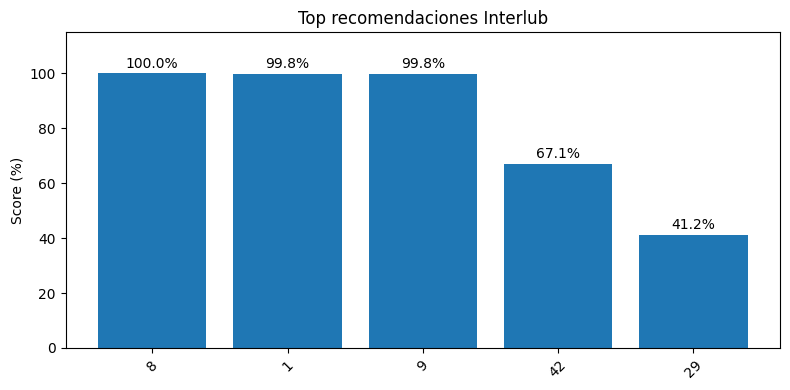

In [109]:
if df_top is not None:
    display(df_top[[
        "Temperatura de Servicio °C, min",
        "Temperatura de Servicio °C, max",
        "Punto de Soldadura Cuatro Bolas, kgf",
        "Resistencia al Lavado por Agua a 80°C, %",
        "Viscosidad del Aceite Base a 40°C. cSt",
        "sim_global", "sim_temp", "sim_carga", "sim_agua", "sim_visc",
        "score_norm"
    ]])
    plot_ranking(df_top)


/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_71180/1691716729.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vals_ideal_norm = np.append(vals_ideal_norm, vals_ideal_norm[0])
/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_71180/1691716729.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vals_prod_norm  = np.append(vals_prod_norm,  vals_prod_norm[0])


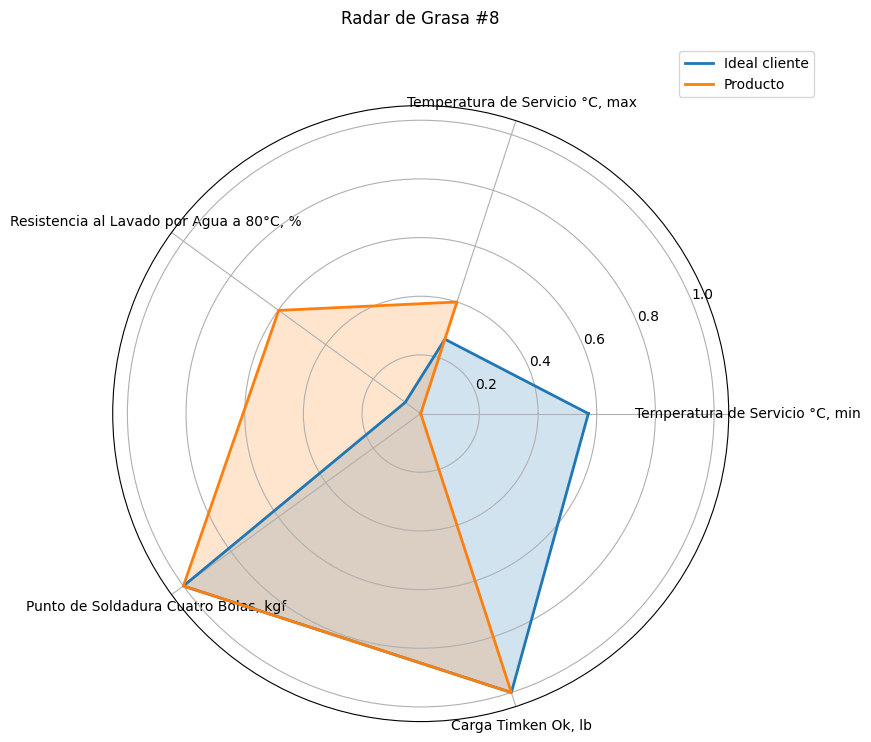

In [ ]:
numeric_cols = [
    "Temperatura de Servicio °C, min",
    "Temperatura de Servicio °C, max",
    "Resistencia al Lavado por Agua a 80°C, %",
    "Punto de Soldadura Cuatro Bolas, kgf",
    "Carga Timken Ok, lb"
]

# vector ideal
fila_ideal_raw = fila_cliente_raw.iloc[0]

# tomar la grasa más recomendada
fila_producto = df_top.iloc[0]

plot_radar_profile(
    df_interlub_raw,
    fila_ideal_raw,
    fila_producto,
    numeric_cols,
    title=f"Radar de Grasa #{fila_producto.name}"
)

In [115]:
df_interlub_raw.sort_values("Punto de Soldadura Cuatro Bolas, kgf", ascending=False).head()

,Aceite Base,Espesante,Viscosidad del Aceite Base a 40°C. cSt,"Penetración de Cono a 25°C, 0.1mm","Punto de Gota, °C","Estabilidad Mecánica, %","Punto de Soldadura Cuatro Bolas, kgf","Desgaste Cuatro Bolas, mm",Indice de Carga-Desgaste,"Carga Timken Ok, lb","Resistencia al Lavado por Agua a 80°C, %",Corrosión al Cobre,Factor de Velocidad,"Temperatura de Servicio °C, min","Temperatura de Servicio °C, max",color,textura
10,Mineral HT,Complejo Sulfonato de Calcio,800.0,269.0,304,1.5,900.0,0.5,166.0,70.0,2.8,1a,300000.0,-8,150,Negro,Adherente
7,Mineral HT,Complejo Sulfonato de Calcio,800.0,370.0,304,1.6,900.0,0.5,166.0,70.0,NaN,1a,300000.0,-30,150,Negro,Adherente
11,Mineral HT,Complejo Sulfonato de Calcio,800.0,248.0,304,3.8,900.0,0.5,166.0,70.0,2.4,1a,300000.0,5,150,Negro,Adherente
1,Mineral HT,Complejo Sulfonato de Calcio,460.0,300.0,304,2.6,900.0,0.5,166.0,70.0,3.0,1a,300000.0,-30,150,Negro,Adherente
8,Mineral HT,Complejo Sulfonato de Calcio,800.0,312.0,304,1.6,900.0,0.5,166.0,70.0,3.0,1a,300000.0,-30,150,Negro,Adherente


In [116]:
df_interlub_raw.sort_values("Resistencia al Lavado por Agua a 80°C, %").head()

,Aceite Base,Espesante,Viscosidad del Aceite Base a 40°C. cSt,"Penetración de Cono a 25°C, 0.1mm","Punto de Gota, °C","Estabilidad Mecánica, %","Punto de Soldadura Cuatro Bolas, kgf","Desgaste Cuatro Bolas, mm",Indice de Carga-Desgaste,"Carga Timken Ok, lb","Resistencia al Lavado por Agua a 80°C, %",Corrosión al Cobre,Factor de Velocidad,"Temperatura de Servicio °C, min","Temperatura de Servicio °C, max",color,textura
27,Mineral USP,Complejo Sulfonato de Calcio,100.0,290.0,304,1.4,500.0,0.35,NaN,40.0,0.02,NaN,900000.0,-5,180,Beige,Suave
26,Mineral USP,Complejo Sulfonato de Calcio,100.0,325.0,304,1.4,500.0,0.35,NaN,40.0,0.02,NaN,900000.0,-5,180,Beige,Suave
40,Mineral HT,Complejo Sulfonato de Calcio,1500.0,300.0,304,1.0,620.0,0.45,NaN,60.0,0.30,1a,200000.0,-5,190,Ambar,Adherente
41,Mineral HT,Complejo Sulfonato de Calcio,1500.0,280.0,304,1.0,620.0,0.45,NaN,60.0,0.30,1a,200000.0,-5,190,Ambar,Adherente
32,Mineral HT,Complejo de Aluminio - Poliurea,680.0,230.0,260,5.2,620.0,0.48,98.0,50.0,0.32,1a,200000.0,5,150,Beige,Adherente


In [117]:
df_interlub_raw.sort_values("Temperatura de Servicio °C, max", ascending=False).head()

,Aceite Base,Espesante,Viscosidad del Aceite Base a 40°C. cSt,"Penetración de Cono a 25°C, 0.1mm","Punto de Gota, °C","Estabilidad Mecánica, %","Punto de Soldadura Cuatro Bolas, kgf","Desgaste Cuatro Bolas, mm",Indice de Carga-Desgaste,"Carga Timken Ok, lb","Resistencia al Lavado por Agua a 80°C, %",Corrosión al Cobre,Factor de Velocidad,"Temperatura de Servicio °C, min","Temperatura de Servicio °C, max",color,textura
18,NaN,Silica,680.0,240.0,304,9.80,315.0,NaN,NaN,40.0,5.00,NaN,NaN,0,240,Ambar,Suave
0,Semi-Sintetico,Complejo Sulfonato de Calcio,680.0,279.0,304,1.07,500.0,NaN,NaN,60.0,0.58,NaN,200000.0,5,220,CafÃ©,Suave
17,NaN,Silica,680.0,280.0,400,8.00,800.0,NaN,NaN,NaN,5.00,NaN,NaN,5,210,Beige,Adherente
12,Mineral Refinado,Complejo Sulfonato de Calcio,460.0,320.0,304,0.80,500.0,NaN,NaN,60.0,0.40,NaN,NaN,-20,190,CafÃ© Claro,Suave
13,Mineral Refinado,Complejo Sulfonato de Calcio,460.0,280.0,304,0.80,500.0,NaN,NaN,60.0,0.40,NaN,NaN,-20,190,CafÃ© Claro,Suave
